In [ ]:
# Authors:
# Eduardo Iraola                              https://iraola.github.io/
# Antonio del Rio Chanona                     https://www.imperial.ac.uk/people/a.del-rio-chanona

# Optimisation and Machine Learning for Process Systems Engineering:
# https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/about-us/


# Anomaly Detection Algorithms - Machine Learning for Chemical Engineering
* Anomalous data is scarce, therefore in this type of problems we can only use normal operation data for training. The few instances of fault behavior we have are left for cross-validation purposes.
* We face a semisupervised problem. We know the labels of normal instances only and we only feed the training with them. The distinction between both classes must be made *after* and not *during* training through some kind of threshold tuning.
* Typical methods used range from statistical, neural networks, distance-based, and other unsupervised and semi-supervised methods.

# 1. Warm-up: Probabilistic approach with a single variable example

In this example, we are generating temperature data from a chemical reactor. We have two sets of data:

- The training set, which we are certain contains normal operation conditions (NOC) only
- The cross-validation set, which contains a mix of both normal and anomaly conditions

We will use statistical methods to try to predict the state of the system in the validation dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
np.random.seed(52)

## 1.1 Data generation

We will generate the data using the `gen_monovariate_data` function. Internally, this function calls `gen_data_train` and `gen_data_test` to generate the training and testing data sets, respectively.

In [ ]:
# Initialization
mean = 400           # Mean of the normal distribution
std = 3              # Standard deviation of the normal distribution
n_noc_test = 100     # Number of test samples
n_fault_slice=50     # Number of data points in the fault slice
n_slice=10           # Number of slices

In [ ]:
def gen_data_train(mean, std, n_noc=500):
    # Generate normal operation conditions (NOC) data
    X_train = np.random.normal(mean, std, n_noc)    
    return X_train

In [ ]:
def gen_data_test(mean, std, n_noc=100, n_fault_slice=50, n_slice=10):
    # Generate anomaly data with drift. 50 slices of 10 points each
    # Total numer of samples is = n_noc + n_fault_slice * n_slice
    changeRate = 1.02
    X_test = np.random.normal(mean, std, n_noc)

    poisson_variable = np.random.poisson(0.05, n_fault_slice)
    mu_fault = mean
    sigma_fault = std
    for i in range(0, n_fault_slice):
        mu_fault = mu_fault * (changeRate ** poisson_variable[i])
        sigma_fault = sigma_fault * (changeRate ** poisson_variable[i])
        next_fault_data = np.random.normal(mu_fault, sigma_fault, n_slice)
        X_test = np.concatenate((X_test, next_fault_data)) 
          
    return X_test

In [ ]:
def gen_monovariate_data(mean, std, n_noc_test, n_fault_slice, n_slice):
    X_train = gen_data_train(mean, std)
    X_test = gen_data_test(mean, std, n_noc_test, n_fault_slice, n_slice)
    return X_train, X_test

In [ ]:
# generating the training and test data
X_train, X_test = gen_monovariate_data(mean, std, n_noc_test, n_fault_slice, 
                                       n_slice)

## 1.2 Data Analysis

We should check the **normality assumption** (assume that our data follows a Gaussian distribution) of the generated data. A typical way is to plot a quartile-quartile plot and check its linearity. 

See this [link](https://library.virginia.edu/data/articles/understanding-q-q-plots#:~:text=A%20QQ%20plot%20is%20a,truly%20come%20from%20normal%20distributions.) for furhter information about quartile-quartile plots.

In [ ]:
import numpy as np
import statsmodels.api as sm
import pylab

sm.qqplot((X_train - X_train.mean(axis=0)) / X_train.std(axis=0), line='45')
pylab.show()

It is also important to visualize the behaviour of normal data.

In [ ]:
# Time-series plot
x = np.linspace(X_train.min() - 2, X_train.max() + 2, 1000)
plt.plot(X_train)
plt.title('Normal operation data against time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.show()

# Histogram
plt.hist(X_train, 20, density=True, facecolor='g', alpha=0.75, label='data')
plt.plot(x, scipy.stats.norm.pdf(x, mean, std), color='black', label='normal distribution')
plt.xlabel('Temperature')
plt.xlim(min(x), max(x))
plt.legend(loc='best')
plt.show()

We can select a specific threshold over which any value will be considered an anomaly. A typical one is $2\sigma$, which corresponds with about a 95 % confidence level

Note that, in real-life examples, we do not know the exact mean and standard deviation of our data. Therefore, the way to work with them is estimating the mean and standard deviation of our sample in the training set.

In [ ]:
mean_train = X_train.mean()
std_est = X_train.std()
th_lower = mean_train - 2 * std_est
th_higher = mean_train + 2 * std_est
print(f'Mean: {mean_train:.2f}')
print(f'Standard deviation: {std_est:.2f}')
print(f'Thresholds. Lower limit: {th_lower:.2f}. Upper limit: {th_higher:.2f}')

Let's visualize how these thresholds look like in the probability density function

In [ ]:
# Get NOC bounds
x_fill = np.linspace(th_lower, th_higher)
fig_pdf, ax_pdf = plt.subplots()
ax_pdf.plot(x, scipy.stats.norm.pdf(x, mean, std), color='black', label='normal distribution')
ax_pdf.fill_between(x_fill, scipy.stats.norm.pdf(x_fill, mean, std), color='grey')
# Get anomaly bounds
x_fault = np.linspace(min(x), th_lower)
ax_pdf.fill_between(x_fault, scipy.stats.norm.pdf(x_fault, mean, std), color='salmon')
x_fault = np.linspace(th_higher, max(x))
ax_pdf.fill_between(x_fault, scipy.stats.norm.pdf(x_fault, mean, std), color='salmon')
ax_pdf.set_xlim(mean - 10, mean + 10)
ax_pdf.set_ylim([0, None])
ax_pdf.set_xlabel('Temperature')

Now let's visualize the faulty data (`X_test`).

In [ ]:
# Time series plot
x_fault = np.arange(1, len(X_test) + 1)
plt.plot(x_fault, X_test)
plt.axvline(n_noc_test, color='salmon', label='fault starts')

plt.plot([x_fault[0], x_fault[-1]], [th_higher, th_higher], 'r--')
plt.plot([x_fault[0], x_fault[-1]], [th_lower, th_lower], 'r--')

plt.title('Anomaly generation against time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.legend(loc='best')
plt.show()

# Histogram
ax_pdf.hist(X_test, 20, density=True, facecolor='g', alpha=0.75, label='anomaly data')
ax_pdf.legend(loc='best')
fig_pdf

## 1.3 Performance on cross-validation

Now is your turn to assess how good your model is. You need to write python code to obtain the predicted labels (normal or faulty). The predicted probability of a data point must be whithin the lower and upper thresholds in order to be considered normal data.

Plot the predictions and discuss the results. 

In [ ]:
####### START YOUR CODE HERE #######

####### END YOUR CODE HERE #########

Let's obtain a metric for how well does this anomaly detector worked.

##### Click here to unveil an example answer

```python
# First we get the actual labels of our cross-validation set
# We know that the first 100 instances are normal, while the fault starts
#  from that point onwards
y_true = np.concatenate((
    np.zeros((n_noc_test,)),
    np.ones((n_fault_slice * n_slice))
))
# Then we get the predicted labels.
y_pred = (X_test > th_higher) | (X_test < th_lower)

# Plot our prediction
plt.plot(x_fault[y_pred == 0], X_test[y_pred == 0], 'b.', label='predicted as normal')
plt.plot(x_fault[y_pred == 1], X_test[y_pred == 1], 'rx', label='predicted as anomaly')
plt.title('Anomalies detected over time')
plt.xlabel('Time (s)')
plt.ylabel('Reactor Temperature')
plt.legend(loc='best')

# Use the accuracy_score function from skit-learn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"The obtained accuracy is {accuracy * 100:0.2f} %")
```

Note that due to our threshold, a few false positives take place. This is a common trade-off in anomaly detection:
- **It is usually difficult to avoid both false positives and false negatives** at the same time
- The determination of the threshold is an important task that the engineer must take into account to give more weight to one or another.
- This depends heavily on the application: e.g. in medical applications, false positives are highly discouraged, while spam detection might be more indulgent in that sense

Also note that the fault takes quite a while to manifest, from it start at $t=100$ min to the first visually noticeable drift at aroun $t=300$ min. More advanced methods might help us anticipate this anomaly but, without more variables showing more hints, it can be impossible to increase our accuracy.

# 2. Probabilistic approach - Multivariate example

Now, consider a more complex case with generic 10 variables that conform a dataset representative of the state of the system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
np.random.seed(4)

## 2.1 Data generation

The function `generate_multivariate_normal_dataset` produces the normal and faulty multivariate data. This function returns a dataframe and a numpy array with the data. The function takes the following inputs:
- `mean`: mean vector of the distribution in normal operation conditions.
- `covariance`: covariance matrix of the distribution in normal operation conditions.
- `n`: total number of points to generate.
- `perc_noc`: percetange of the normal data points that are in normal operation conditions. 
- `changing_rate`: changing rate. Needed for generating the faulty data.

Optionally you can provide the random state (`rng`) and if you want to shuffle the data (`shuffle`).

**Note**: Take your time to understand how the data is generated.


In [49]:
def generate_multivariate_normal_dataset(mean, covariance, n, perc_noc, changing_rate, rng=None, shuffle=False):
  n_noc = int (n * perc_noc)
  n_fault = n - n_noc
  x_noc = np.zeros((n_noc, 10))
  x_fault = np.zeros((n_fault, 10))
  cols = ['x1', 'x2', 'x3', 'x4','x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'label']

  # Generate data under normal conditions
  x_noc = rng.multivariate_normal(mean=mean, cov=covariance, size=n_noc)
  label_noc = np.zeros(n_noc)
  label_noc = label_noc.reshape((len(label_noc), 1))
  data_noc = np.concatenate((x_noc, label_noc), axis=1)

  # Generate data include fault
  poisson_generator = rng.poisson(0.2, n_fault)
  label_poisson = np.ones(n_fault)
  for j in range(n_fault):
    if poisson_generator[j] != 0:
        label_poisson[0:j+1] = 0
        break

  # Depends on whether mean or cov is changing
  mean_fault = mean
  cov_fault = covariance

  for i in range(x_fault.shape[0]):
    if poisson_generator[i] != 0:
        cov_fault[0,1] *= (1+changing_rate)**(poisson_generator[i])
        cov_fault[1,0] *= (1+changing_rate)**(poisson_generator[i])
    instance = rng.multivariate_normal(mean=mean_fault, cov=cov_fault, size=1)
    x_fault[i] = instance

  label_poisson = label_poisson.reshape((len(label_poisson), 1))
  data_fault = np.concatenate((x_fault, label_poisson), axis=1)

  data_np = np.concatenate((data_noc, data_fault), axis=0)
  data = pd.DataFrame(data_np, columns=cols)

  if shuffle == True:
    data = data.sample(frac=1, random_state=rng)# .reset_index(drop=True)
    data_np = data_np[data.index]
    data.reset_index(drop=True, inplace=True)

  return data, data_np

Now we will use the `generate_multivariate_normal_dataset` function to generate the training and testing data sets of the multivariate distribution.

In [50]:
# Generate data
n_samples = 500
perc_noc_train = 1   # % NOC instances in the training set (100 %)
perc_noc_test = 0.2  # % NOC instances in the test set (100 %)
changing_rate = 0.15
base_rng      = np.random.default_rng(42)


# Generate means
mean = base_rng.integers(low=1, high=10, size=10)
print('The mean of the distribution in NOC is: ', mean)

# Generate covariance
covariance = np.array([[2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5, 0.5],
                      [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0, -0.5],
                      [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 2.0]])
print('The covariance of the distribution in NOC is :', covariance)

# Generate numpy data and do train-test split
data_train, data_train_np = generate_multivariate_normal_dataset(
    mean, covariance, n_samples, perc_noc_train, changing_rate, rng=base_rng, 
    shuffle=False)
data_test, data_test_np = generate_multivariate_normal_dataset(
    mean, covariance, n_samples, perc_noc_test, changing_rate, rng=base_rng, 
    shuffle=False)
X_train = data_train.drop(['label'], axis=1).to_numpy()
y_train = data_train['label'].to_numpy()
X_test = data_test.drop(['label'], axis=1).to_numpy()
y_test = data_test['label'].to_numpy()

# The features of the dataset correspond to the columns of X_train
n_features = X_train.shape[1]

The mean of the distribution in NOC is:  [1 7 6 4 4 8 1 7 2 1]
The covariance of the distribution in NOC is : [[ 2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5 -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2.  -0.5]
 [-0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  2. ]]


/var/folders/hd/26k9wn_n6vlf4rxz8dd_gzxh0000gp/T/ipykernel_64960/407381411.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  instance = rng.multivariate_normal(mean=mean_fault, cov=cov_fault, size=1)


In this case, the dataset is completly random, and disturbances are introduced in the covariance between the first and second variable, which starts suffering a drift based on a Poisson disturbance like in the single-variable example

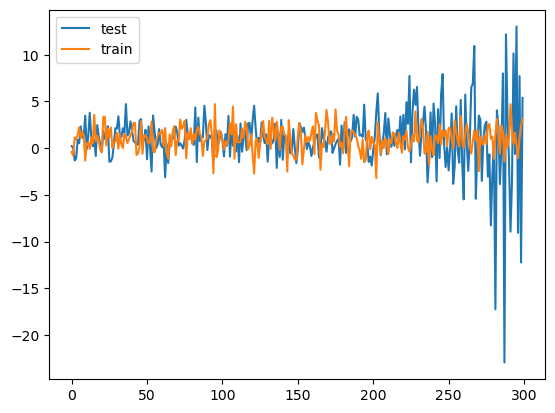

In [48]:
plt.plot(data_test.iloc[:300,0], label='test')
plt.plot(data_train.iloc[:300,0], label='train')
plt.legend(loc='best')

## 2.2 Anomaly detection


We are going to estimate the detection thresholds for each variable separately. For this, we use the probability density function of the normal distribution

$$ f(x_i|\mu, \Sigma) = \frac{1}{{\sqrt{(2 \pi)^n \Sigma}}} e^{-\frac{1}{2}{(x - \mu)^T \Sigma^{-1} {(x - \mu)}}}$$ 

Note that the probability density function is not exactly yielding probabilities, but a measure of the density of the random distribution at a specific point. However, it can be used to locate points in the probability distrubution ranges.

In [ ]:
def probability_density(X, mean, var):
    """
    Calculate the probability density of a series of instances in X given the
    multivariate mean and covariance matrix.
    """
    n = len(mean)
    if var.ndim == 1:
        var = np.diag(var)
    X = X - mean
    p = (2 * np.pi)**(- n/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    if len(p) == 1:
        return p[0]
    else:
        return p

Now we estimate the means and covariance of our system using the training set

In [ ]:
# Estimate Gaussian distribution
mean_train = np.mean(X_train, axis=0)
cov_train = np.cov(X_train, rowvar=False)  # By default it deals with each row as a variable

Fit the threshold using the training set

In [ ]:
def get_threshold(scores, y_true, target_acc=0.95, positive_lower=True, 
                  n_samples=1e4, print_stdout=True, plot=True):
    """ 
    Obtain threshold by searching for the closest accuracy to target_acc via 
    brute force.
    ----------
    Parameters
    ----------
    positive_lower: if True, positive instances are predicted when the score
        is lower than the threshold. If False, positive instances are predicted
        for scores higher than the threshold
    """
    # Get extremes of scores
    scores_range = np.linspace(scores.min(), scores.max(), int(n_samples))
    # Loop them until finding the closer value to 95 % accuracy (brute force)
    error_old = 1
    accs = {}
    for score_th in scores_range:
        # Obtain predictions given the current threshold
        if positive_lower:
            y_pred = scores < score_th
        else:
            y_pred = scores > score_th
        # Calculate accuracy and measure the error with respect target_acc
        acc = accuracy_score(y_true, y_pred)
        accs[score_th] = acc
        error = (target_acc - acc) ** 2
        if print_stdout:
            print(f"Obtained accuracy {acc}, error {error}" 
                  f" with threshold = {score_th}")
        if error < error_old:
            threshold = score_th 
            error_old = error
        elif error > error_old:
            # Avoid continuing since no better error will be obtained
            break
    if plot:
        plt.figure()
        plt.plot(pd.Series(accs), label='evolution of accuracy')
        plt.vlines(threshold, plt.gca().get_ylim()[0], 1, color='red', label='final threshold')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
    return threshold

In [ ]:
# Get probabilities and threshold
probs = probability_density(X_train, mean_train, cov_train)
threshold = get_threshold(probs, y_train, positive_lower=True, n_samples=1e5)

Check if we obtain the desired accuracy

In [ ]:
y_train_pred = probability_density(X_train, mean_train, cov_train) < threshold
print(f'We should have {int(len(X_train) * 0.05)} false positives.')
print(f'We have {sum(y_train_pred)} false positives')

Now that we have our threshold, we can evaluate the test set. Remember we use the fitted mean and variance from the training set, we do not obtain these from the test set.

In [ ]:
p_test = probability_density(X_test, mean_train, cov_train) 
y_test_pred = p_test < threshold
acc_test = accuracy_score(y_test, y_test_pred)
print(f'The obtained accuracy is {acc_test *100} %')

# 3. Proximity-based approaches - Clustering example

In this example, we are going to work with the iris dataset, which has become famous among the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is linearly separable from the other 2; the latter are not linearly separable from each other.

![Iris dataset](https://upload.wikimedia.org/wikipedia/commons/c/cb/Flores_de_%C3%8Dris.png)

**Exercise**: Use k-means clustering to perform anomaly detection on the iris dataset.

- The training set consists on the 'setosa' and 'virginica' (first and third class) data points.
- The test set consists on the 'versicolor' instances.
- As a simplification, use only the first and the last features of the dataset: the sepal length and the petal width.

New instances should be classified as an anomaly if they do not belong to one of the known labels: 'setosa' or 'virginica'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import accuracy_score

# Load dataset
iris = datasets.load_iris()
print('Features: ', iris.feature_names)
print('Iris flower names:', iris.target_names)

n_clusters = 2  # We assume our training set is composed of 2 clusters


In [ ]:
# Plot the data
fig_orig, ax_orig = plt.subplots()
scatter = ax_orig.scatter(iris.data[:, 0], iris.data[:, 3], c=iris.target)
ax_orig.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[3])
ax_orig.legend(scatter.legend_elements()[0], iris.target_names, 
          loc="lower right", title="Classes")

In [ ]:
# Perform train-test split
y = iris.target
X_train = iris.data[:, [0, 3]][y != 1]  # [0,3] to get first and fourth feature
                                        # [y != 1] to get all classes except 1
X_test = iris.data[:, [0, 3]][y == 1]   # Same for the test set
y_train = np.zeros((len(X_train),))
y_test = np.ones((len(X_test),))
X_train.shape, X_test.shape

In [ ]:
# Fit k-means model with two clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)
kmeans.labels_, kmeans.cluster_centers_

In [ ]:
# Plot cluster predictions
_, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[3])
ax.legend(scatter.legend_elements()[0], iris.target_names, 
          loc="lower right", title="Classes")
print('We can see that k-means correctly separates the two classes except for one single point')

Now we have fitted our model we can try to predict anomalies. The algorithm would go as follows. For any new instance:

1. Associate the new instance with the closest cluster centroid.
2. Calculate a probabilistic/distance-based anomaly metric
3. Classify the new instance as normal or anomaly depending on a threshold previously selected

We calculate a threshold for each cluster

In [ ]:
X_train[kmeans.labels_ == 1].shape

In [ ]:
th_clusters = []
mean_clusters = []
cov_clusters = []
for i in range(n_clusters):
    X_train_cluster = X_train[kmeans.labels_ == i]
    y_train_cluster = np.zeros(len(X_train_cluster))
    # Estimate Gaussian distribution of each cluster
    mean_train = np.mean(X_train_cluster, axis=0)
    mean_clusters.append(mean_train)
    cov_train = np.cov(X_train_cluster, rowvar=False)
    cov_clusters.append(cov_train)
    # Get probabilities and threshold
    probs = probability_density(X_train_cluster, mean_train, cov_train)
    th = get_threshold(probs, y_train_cluster, positive_lower=True, 
                       n_samples=1e4, print_stdout=False, plot=False)
    th_clusters.append(th)
print('Thresholds are', th_clusters)

Calculate the accuracy on our training set

In [ ]:
y_train_pred = np.zeros(len(X_train))
scores = np.zeros(len(X_train))
for i in range(len(X_train)):
    # Reshape instance to make it 2-dimensional
    x = X_train[i, :].reshape(1, -1)
    cluster_idx = kmeans.labels_[i]
    # print(f'Point {i} belongs to cluster {cluster_idx}')
    # Calculate the Mahalanobis distance
    scores[i] = probability_density(
        x, mean_clusters[cluster_idx], cov_clusters[cluster_idx])
    # Predict anomaly
    y_train_pred[i] = scores[i] < th_clusters[cluster_idx]
print(f'The accuracy on the train set is {accuracy_score(y_train, y_train_pred) * 100} %')

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_pred)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[3])
ax.legend(scatter.legend_elements()[0], ['normal', 'anomaly'], 
          loc="lower right", title="Classes")

For new instances (test set) determine closest cluster and compare distances to threshold

In [ ]:
y_test_pred = np.zeros(len(X_test))
scores = np.zeros(len(X_test))
for i in range(len(X_test)):
    # Rehape instance to make it 2-dimensional
    x = X_test[i, :].reshape(1, -1)
    cluster_idx = kmeans.predict(x)[0]
    # Calculate the Mahalanobis distance
    scores[i] = probability_density(
        x, mean_clusters[cluster_idx], cov_clusters[cluster_idx])
    # Predict anomaly
    y_test_pred[i] = scores[i] < th_clusters[cluster_idx]
print(f'The accuracy on the test set is {accuracy_score(y_test, y_test_pred) * 100} %')

Compare our anomaly detection results with the actual classes

In [ ]:
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred)
fig

In [ ]:
# Compare with the original classes
fig_orig

# 4. Neural networks: autoencoders

Neural networks are usually trained in a supervised manner. To be able to use them in a semisupervised problem, we cannot use the typical feedforward neural network. For this, the self-associative neural networks, also called autoencoders, come to help. Their name is self-explanatory: the goal of autoencorders is to try to reproduce the input in the output of the neural network. This may look like a trivial task but the trick here is that there is a bottleneck in the architecture of the network that causes a loss of information.

The training phase tries to make the reconstruction with the lowest possible loss despite the bottleneck. This way it is able to find the most important features and discard noise that is useless to reconstruct the input. Its usefulness in anomaly detection comes with that, if trained with normal operation data and learns to identify and reconstruct it correctly when an abnormal event occurs, the reconstruction will show an important bias compared with nominal operation data.

Therefore, they do not use labels to train the network. However, we need to know that all the instances fed during training belong to the same class (usually the *normal operation* class), therefore the *semisupervised* surname of it.

**Exercise**: We will work with the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. For this, we will try to identify as an anomaly every number that is not a "5"

![MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

First, we will load the dataset from the scikit-learn builtin datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Import tensorflow to download higher resolution mnist dataset
# Otherwise sklearn will be used
from sklearn import datasets

In [ ]:
def plot_mnist(X, y, n=3, title=''):
    """ Distribute plots in rows of 4. """
    import math
    # Get number of pixels in each dimension
    side_px = int(math.sqrt(X.shape[1]))
    nrows = math.ceil(n / 4)
    ncols = 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    i = 0
    for image, label in zip(X, y):
        #np.unravel_index(i, axes.shape)
        ax = axes.flatten()[i]
        ax.set_axis_off()
        image = image.reshape(side_px, side_px)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        if not label:
            ax.set_title(f"Label: {bool(label)}", fontweight="bold")
        else:
            ax.set_title(f"Label label: {bool(label)}")
        i += 1
        if i >= n:
            break
    fig.suptitle(title)


def get_mnist_5(split=False):
    # Load data
    try:
        (X_train, y_train), (X_test, y_test) = \
            tf.keras.datasets.mnist.load_data()
        # Unroll pixels to follow sklearn setup
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))
        # Set up labels to this specific case
        y_train = ~(y_train == 5)
        y_test = ~(y_test == 5)
        return X_train, X_test, y_train, y_test
    except:
        digits = datasets.load_digits()

        # Get input and output data
        X = digits.data
        labels = digits.target
        y = ~(labels == 5)

        if split:
            # Split data into 50% train and 50% test subsets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, shuffle=True
            )
            return X_train, X_test, y_train, y_test
        else:
            return X, y
    
    
X_train, X_test, y_train, y_test = get_mnist_5(split=True)
plot_mnist(X_train, y_train, n=12)
print("Five's are represented as False (normal), "
      "while the rest are considered True (anomaly)")

# Keep only 5's for the training set
X_train = X_train[y_train == False]
y_train = y_train[y_train == False]
plot_mnist(X_train, y_train, n=12)

Each instance of the training set consists of 64 elements that represent the 8-by-8 greyscale pixel image of a handwritten number. Each pixel value ranges from 0 to 16, from white to black

In [ ]:
print('This is an example of the contents of an image.'
      ' The zero-valued pixels correspond to white background')
print(X_train[1, :], y_train[0])

Before working with the data, we need to standardize the pixel intensisty values

In [ ]:
# Scaling (no need of centering in images)
scale_factor = X_train.max()
X_train_scaled = X_train / scale_factor
X_test_scaled = X_test / scale_factor

Now we have our dataset, we can set up our autoencoder neural network.

First, set up the architecture:

In [ ]:
# Shape of input and latent variable
n_input = X_train.shape[1]

# Encoder structure
n_encoder1 = 10
# n_encoder2 = 10
n_latent = 2

# Decoder structure
# n_decoder2 = 10
n_decoder1 = 10

hidden_layer_sizes = (n_encoder1, n_latent, n_decoder1)

Initialize the model using sklearn's [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (Multilayer Perceptron)

In [ ]:
model = MLPRegressor(
    hidden_layer_sizes=hidden_layer_sizes, 
    activation='tanh', 
    solver='adam', 
    batch_size='auto', 
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=None,
    tol=0.0000001,
    verbose=True,
    alpha=0.0001
)

Now we can fit the model. Bear in mind that we want the model to try to obtain a target output as similar as possible to the input.

In [ ]:
model.fit(X_train_scaled, X_train_scaled)

In [ ]:
plt.plot(model.loss_curve_)
plt.xlabel('Training epochs')
plt.ylabel('Loss')

Check how reconstructions go for the trained model.

In [ ]:
def compare_inout_mnist(image_in, image_out):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(image_in, cmap=plt.cm.gray_r, interpolation="nearest")
    axes[0].set_title("Input", fontsize=26)
    axes[0].axis('off')
    axes[1].imshow(image_out, cmap=plt.cm.gray_r, interpolation="nearest")
    axes[1].set_title("Output", fontsize=26)
    axes[1].axis('off')
    plt.show()
    

In [ ]:
# Plot 5
side_px = int(np.sqrt(X_train.shape[1]))
input_image = X_train_scaled[0, :].reshape((side_px,  side_px))
# Perform reconstruction through autoencoder
reconstructed_image = model.predict(X_train_scaled[0:0 + 1, :])
side_px = int(np.sqrt(X_train.shape[1]))
reconstructed_image = reconstructed_image.reshape((side_px, side_px))
compare_inout_mnist(input_image, reconstructed_image)

In [ ]:
# Plot other numbers in the test set
reconstructed_images = []
for i in range(1, 5):
    input_image = X_test_scaled[i, :].reshape((side_px,  side_px))
    # Perform reconstruction through autoencoder
    reconstructed_image = model.predict(X_test_scaled[i:i + 1, :])
    reconstructed_image = reconstructed_image.reshape((side_px, side_px))
    compare_inout_mnist(input_image, reconstructed_image)
    reconstructed_images.append(reconstructed_image)

The anomaly detection algorithm to detect new instances as normal or outliers and obtain a metric of performance is similar to previous exercises and left for the student to complete.